In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [2]:
transactions = pd.read_csv('data/transactions.csv')

years = [20, 21, 22, 23]
scores_list = []
for year in years:
    df = pd.read_csv(f'data/scores_{year}.csv')
    df['Year'] = year
    scores_list.append(df)
    
scores = pd.concat(scores_list, ignore_index=True)
scores['organization'] = pd.to_numeric(scores['organization'], errors='coerce')
scores['global_satisfaction'] = pd.to_numeric(scores['global_satisfaction'], errors='coerce')
scores['period'] = pd.to_numeric(scores['period'], errors='coerce')
scores['Year'] = scores['Year'].astype(int)

scores


,Trip,organization,global_satisfaction,period,Year
0,Mountain Hiking in the Swiss Alps,6.2,5.3,3,20
1,Kayaking in Costa Brava,7.1,6.9,1,20
2,Cycling Tour in the Pyrenees,7.8,7.4,2,20
3,Historical Tour of Rome,8.5,7.0,4,20
4,Cultural Immersion in Prague,7.7,8.6,1,20
...,...,...,...,...,...
69,Cheese and Chocolate Tour in Switzerland,9.0,8.8,2,23
70,Gourmet Tour of Northern Italy,8.4,7.5,3,23
71,Mediterranean Cruise from Spain to Italy,7.1,7.2,3,23
72,"Castle Tour in Bavaria, Germany",9.3,10.0,3,23


In [3]:
print(transactions.isnull().sum())

Date           0
Customer ID    0
Status         0
Operator ID    0
dtype: int64


In [4]:
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions['Year'] = transactions['Date'].dt.year
transactions['Month'] = transactions['Date'].dt.month
transactions['Quarter'] = transactions['Date'].dt.quarter

transactions['Status'] = transactions['Status'].astype('category')
transactions['Operator ID'] = transactions['Operator ID'].astype('category')

transactions.head(10)

,Date,Customer ID,Status,Operator ID,Year,Month,Quarter
0,2019-01-02,8022947342,Filled in form,O3,2019,1,1
1,2019-06-24,8646438687,Filled in form,O3,2019,6,2
2,2019-04-04,9379000553,Filled in form,O3,2019,4,2
3,2019-02-04,1464743096,Filled in form,O4,2019,2,1
4,2019-04-11,8015744618,Filled in form,O1,2019,4,2
5,2019-03-10,1938140948,Filled in form,O1,2019,3,1
6,2019-06-18,5013136023,Filled in form,O3,2019,6,2
7,2019-05-26,5960945131,Filled in form,O2,2019,5,2
8,2019-05-09,1987742971,Filled in form,O4,2019,5,2
9,2019-06-26,4406283582,Filled in form,O3,2019,6,2


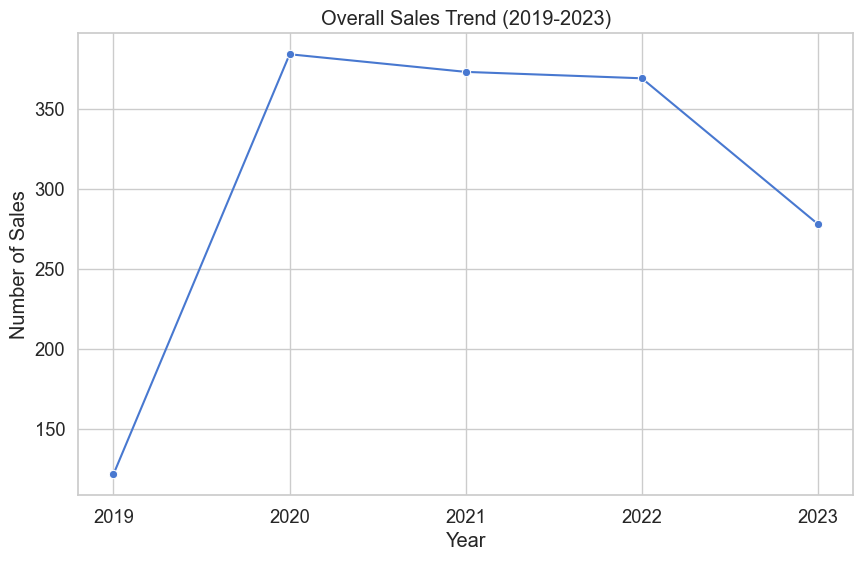

In [5]:
sales_data = transactions[transactions['Status'] == 'Sales']
sales_per_year = sales_data.groupby('Year').size().reset_index(name='Total_Sales')



plt.figure(figsize=(10,6))

sns.lineplot(data=sales_per_year, x='Year', y='Total_Sales', marker='o')
plt.title('Overall Sales Trend (2019-2023)')
plt.ylabel('Number of Sales')
plt.xlabel('Year')
plt.xticks([2019, 2020, 2021, 2022, 2023])
plt.show()


C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\1118725820.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=sales_per_year[sales_per_year['Year']>=2021], x='Year', y='YoY Change (%)', palette = 'viridis')


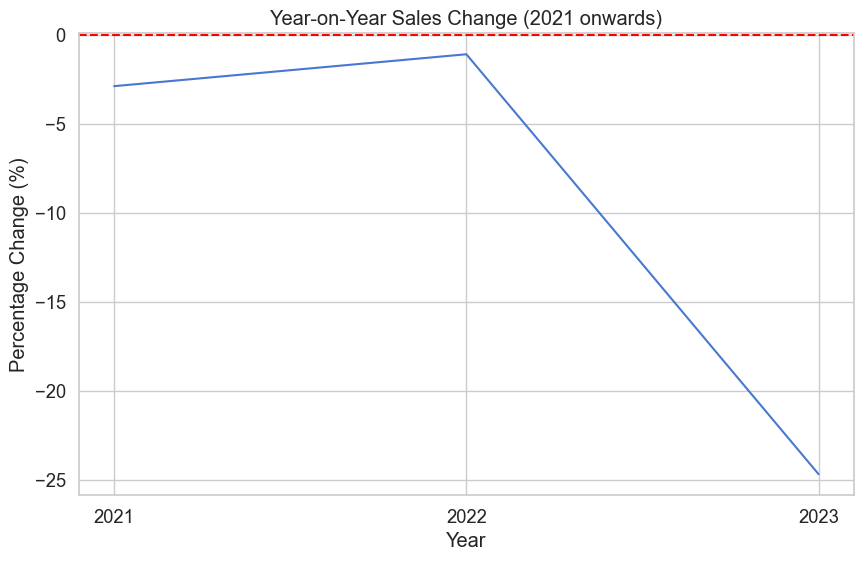

In [6]:
sales_per_year['YoY Change (%)'] = sales_per_year['Total_Sales'].pct_change() * 100

plt.figure(figsize=(10,6))
sns.lineplot(data=sales_per_year[sales_per_year['Year']>=2021], x='Year', y='YoY Change (%)', palette = 'viridis')
plt.title('Year-on-Year Sales Change (2021 onwards)')
plt.ylabel('Percentage Change (%)')
plt.xlabel('Year')
plt.xticks([2021, 2022, 2023])
plt.axhline(0, color='red', linestyle='--')
plt.show()

Status  Year  Filled in form  Paid diposit  Sales  Cancelled  Not reachable
0       2019            2116            31    122         12             46
1       2020            2804           470    384        170            267
2       2021            2577           315    373        104            202
3       2022            2428           211    369         67            145
4       2023            2312           145    278         53            119


C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\835746958.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customers_per_stage = transactions.groupby(['Year', 'Status'])['Customer ID'].nunique().reset_index(name='Customers')


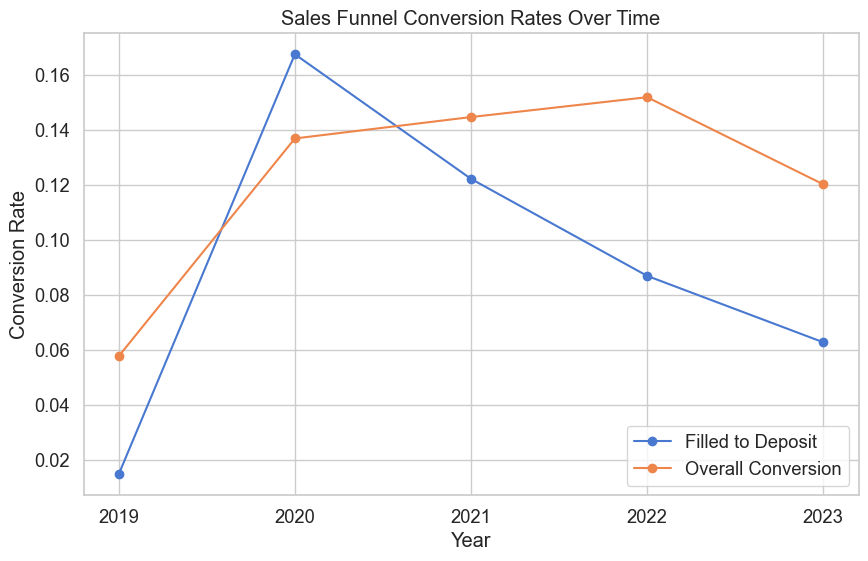

In [7]:
# Define funnel stages in order
stages = ['Filled in form', 'Paid diposit', 'Sales', 'Cancelled', 'Not reachable']

# Count unique customers at each stage per year
customers_per_stage = transactions.groupby(['Year', 'Status'])['Customer ID'].nunique().reset_index(name='Customers')
customers_pivot = customers_per_stage.pivot(index='Year', columns='Status', values='Customers').fillna(0)
customers_pivot = customers_pivot[stages].reset_index()

print(customers_pivot)
# Calculate conversion rates
customers_pivot['Conversion_Filled_to_Deposit'] = customers_pivot['Paid diposit'] / customers_pivot['Filled in form']
customers_pivot['Overall_Conversion'] = customers_pivot['Sales'] / customers_pivot['Filled in form']

# Plotting Conversion Rates
plt.figure(figsize=(10,6))
plt.plot(customers_pivot['Year'], customers_pivot['Conversion_Filled_to_Deposit'], marker='o', label='Filled to Deposit')
plt.plot(customers_pivot['Year'], customers_pivot['Overall_Conversion'], marker='o', label='Overall Conversion')
plt.title('Sales Funnel Conversion Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Conversion Rate')
plt.xticks([2019, 2020, 2021, 2022, 2023])
plt.legend()
plt.show()

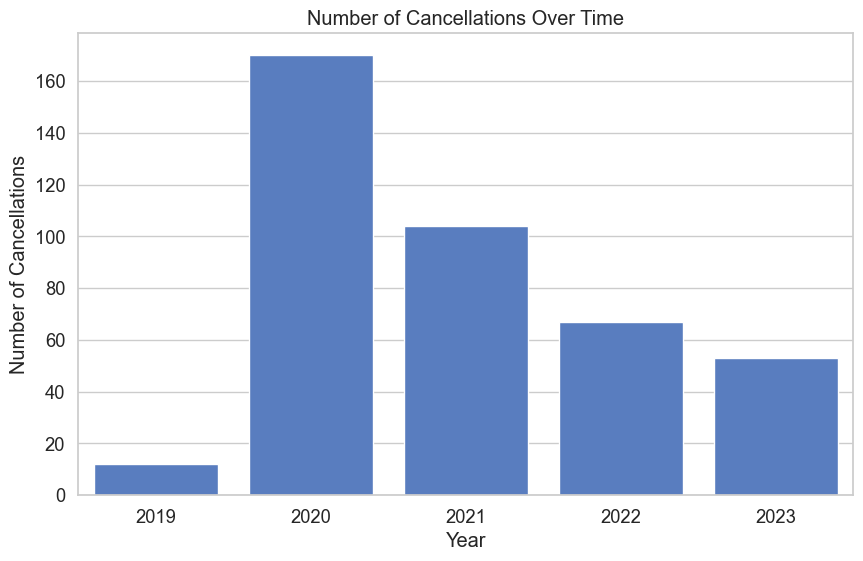

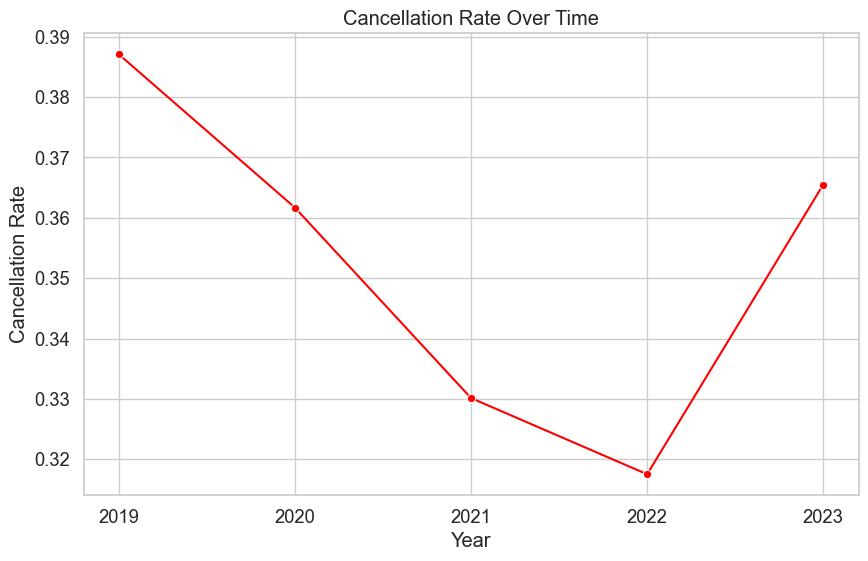

In [8]:
cancelled_per_year = transactions[transactions['Status'] == 'Cancelled'].groupby('Year')['Customer ID'].nunique().reset_index(name='Cancellations')
customers_pivot['Cancellation_Rate'] = customers_pivot['Cancelled']/customers_pivot['Paid diposit']

plt.figure(figsize=(10,6))
sns.barplot(data=cancelled_per_year, x='Year', y='Cancellations')
plt.title('Number of Cancellations Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Cancellations')
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=customers_pivot, x='Year', y='Cancellation_Rate', marker='o', color='red')
plt.title('Cancellation Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Cancellation Rate')
plt.xticks([2019, 2020, 2021, 2022, 2023])
plt.show()


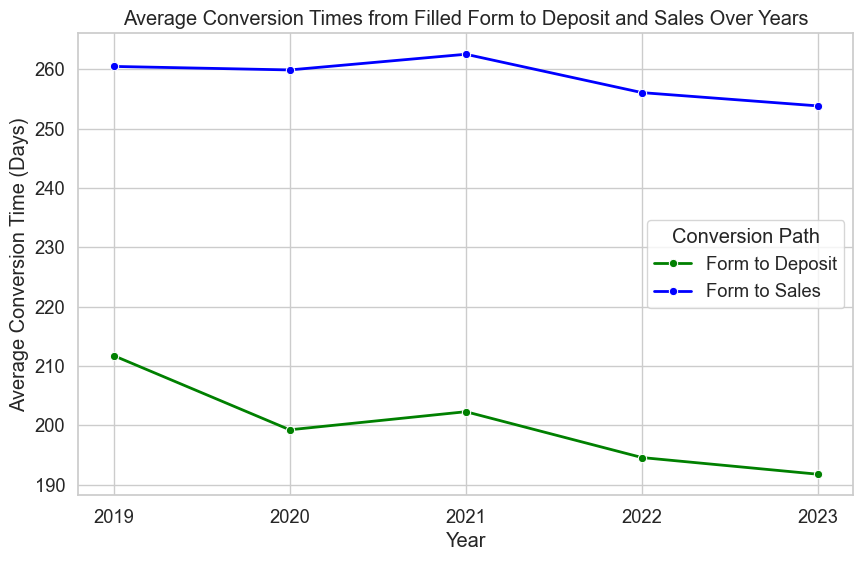

In [9]:
filled_forms = transactions[transactions['Status'] == 'Filled in form'].groupby('Customer ID')['Date'].min().reset_index()
filled_forms.rename(columns={'Date': 'Filled_in_form_Date'}, inplace=True)

sales_dates = transactions[transactions['Status'] == 'Sales'].groupby('Customer ID')['Date'].min().reset_index()
sales_dates.rename(columns={'Date': 'Sales_Date'}, inplace=True)

deposits_paid = transactions[transactions['Status'] == 'Paid diposit'].groupby('Customer ID')['Date'].min().reset_index()
deposits_paid.rename(columns={'Date':'Paid_deposit_date'}, inplace=True)

conversion_times = pd.merge(filled_forms, sales_data, on='Customer ID')
conversion_times = conversion_times.merge(deposits_paid, on = 'Customer ID')

conversion_times['Conversion_Time_Form_to_Sales_Days'] = (conversion_times['Date'] - conversion_times['Filled_in_form_Date']).dt.days
conversion_times['Conversion_Time_Form_to_Deposits_Days'] = (conversion_times['Paid_deposit_date'] - conversion_times['Filled_in_form_Date']).dt.days

conversion_times['Year'] = conversion_times['Date'].dt.year

avg_conversion_time_to_sales = conversion_times.groupby('Year')['Conversion_Time_Form_to_Sales_Days'].mean().reset_index()
avg_conversion_time_to_deposits = conversion_times.groupby('Year')['Conversion_Time_Form_to_Deposits_Days'].mean().reset_index()

# Merge the average times
avg_conversion_times = avg_conversion_time_to_deposits.merge(avg_conversion_time_to_sales, on='Year', how='outer')

# Rename columns for clarity
avg_conversion_times.rename(columns={
    'Conversion_Time_Form_to_Deposits_Days': 'Avg_Time_Form_to_Deposit',
    'Conversion_Time_Form_to_Sales_Days': 'Avg_Time_Form_to_Sales'
}, inplace=True)

# Sort by 'Year'
avg_conversion_times = avg_conversion_times.sort_values('Year')

plt.figure(figsize=(10,6))

# Plot average time from 'Form' to 'Deposit'
sns.lineplot(
    data=avg_conversion_times,
    x='Year',
    y='Avg_Time_Form_to_Deposit',
    marker='o',
    label='Form to Deposit',
    color='green',
    linewidth=2
)

# Plot average time from 'Form' to 'Sales'
sns.lineplot(
    data=avg_conversion_times,
    x='Year',
    y='Avg_Time_Form_to_Sales',
    marker='o',
    label='Form to Sales',
    color='blue',
    linewidth=2
)

plt.title('Average Conversion Times from Filled Form to Deposit and Sales Over Years')
plt.xlabel('Year')
plt.ylabel('Average Conversion Time (Days)')
plt.xticks(avg_conversion_times['Year'])
plt.legend(title='Conversion Path')
plt.grid(True)
plt.show()



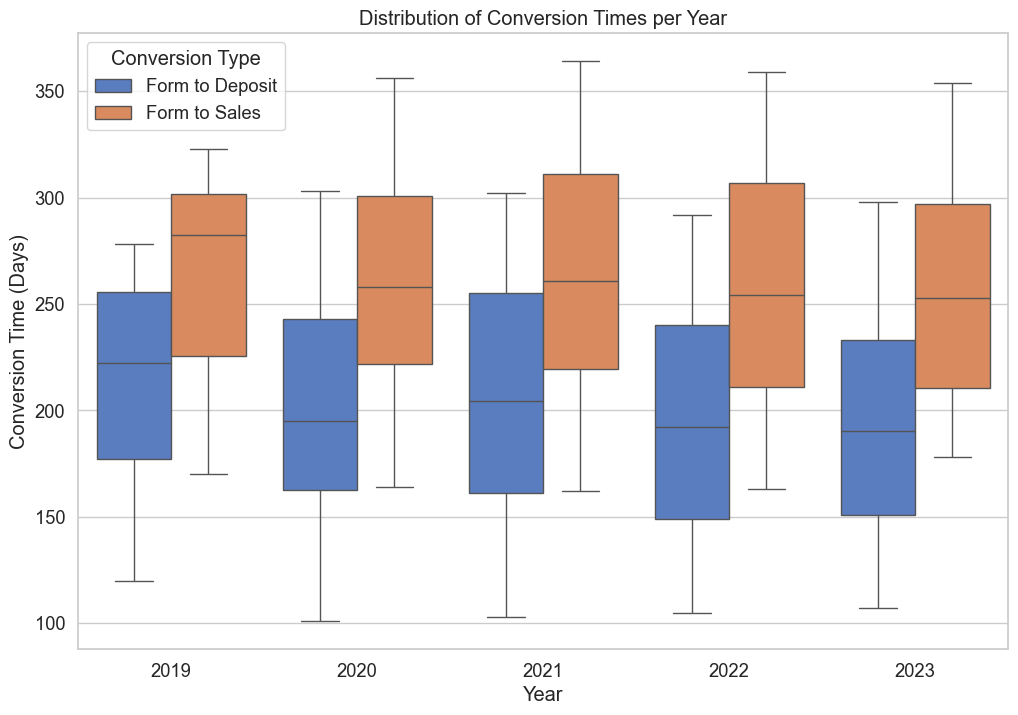

In [10]:
# Melt conversion_times
conversion_times_melted = conversion_times.melt(
    id_vars=['Customer ID', 'Year'],
    value_vars=['Conversion_Time_Form_to_Deposits_Days', 'Conversion_Time_Form_to_Sales_Days'],
    var_name='Conversion_Type',
    value_name='Conversion_Time_Days'
)

#Remove rows with NaN conversion times
conversion_times_melted.dropna(subset=['Conversion_Time_Days'], inplace=True)

#for clarity
conversion_times_melted['Conversion_Type'] = conversion_times_melted['Conversion_Type'].replace({
    'Conversion_Time_Form_to_Deposits_Days': 'Form to Deposit',
    'Conversion_Time_Form_to_Sales_Days': 'Form to Sales'
})

plt.figure(figsize=(12,8))
sns.boxplot(
    data=conversion_times_melted,
    x='Year',
    y='Conversion_Time_Days',
    hue='Conversion_Type'
)
plt.title('Distribution of Conversion Times per Year')
plt.xlabel('Year')
plt.ylabel('Conversion Time (Days)')
plt.legend(title='Conversion Type')
plt.show()

trip_name               object
page_views               int64
unique_visitors          int64
avg_session_duration    object
bounce_rate             object
conversion_rate         object
dtype: object


C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\1079698966.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_year_scores.rename(columns={'Trip':'trip_name'}, inplace=True)


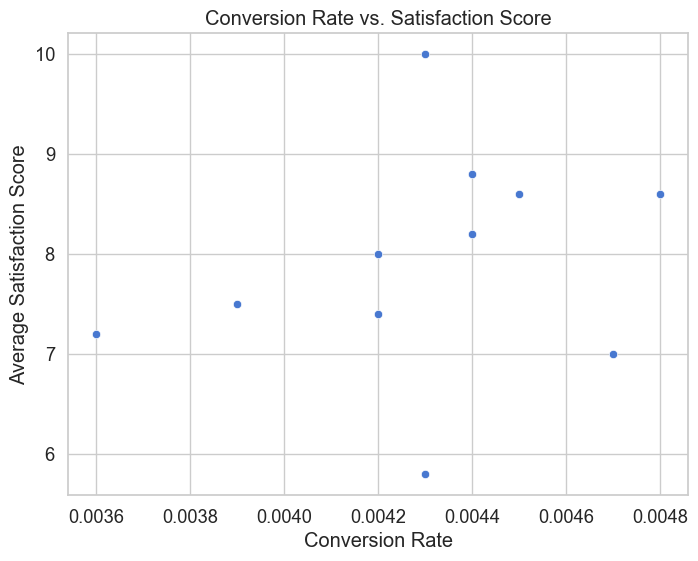

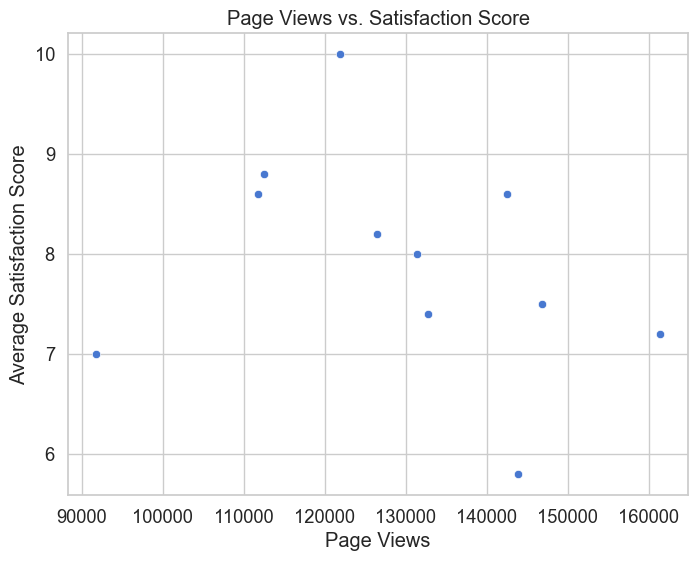

In [11]:
analytics_data = pd.read_csv('data/analytics_data.csv')

print(analytics_data.dtypes)
analytics_data['bounce_rate'] = analytics_data['bounce_rate'].astype(str).str.rstrip('%').astype(float) / 100
analytics_data['conversion_rate'] = analytics_data['bounce_rate'].astype(str).str.rstrip('%').astype(float) / 100
analytics_data['avg_session_duration'] = analytics_data['avg_session_duration'].astype(str).str.rstrip('s').astype(float)

analytics_data['trip_name'] = analytics_data['trip_name'].str.strip()

last_year_scores = scores[scores['Year'] == 23]
last_year_scores.rename(columns={'Trip':'trip_name'}, inplace=True)

trip_analytics_satisfaction = analytics_data.merge(last_year_scores, on = 'trip_name', how = 'left').dropna().reset_index()

# Plotting conversion rate vs. satisfaction scores
plt.figure(figsize=(8,6))
sns.scatterplot(data=trip_analytics_satisfaction, x='conversion_rate', y='global_satisfaction')
plt.title('Conversion Rate vs. Satisfaction Score')
plt.xlabel('Conversion Rate')
plt.ylabel('Average Satisfaction Score')
plt.show()

# Plotting page views vs. satisfaction scores
plt.figure(figsize=(8,6))
sns.scatterplot(data=trip_analytics_satisfaction, x='page_views', y='global_satisfaction')
plt.title('Page Views vs. Satisfaction Score')
plt.xlabel('Page Views')
plt.ylabel('Average Satisfaction Score')
plt.show()


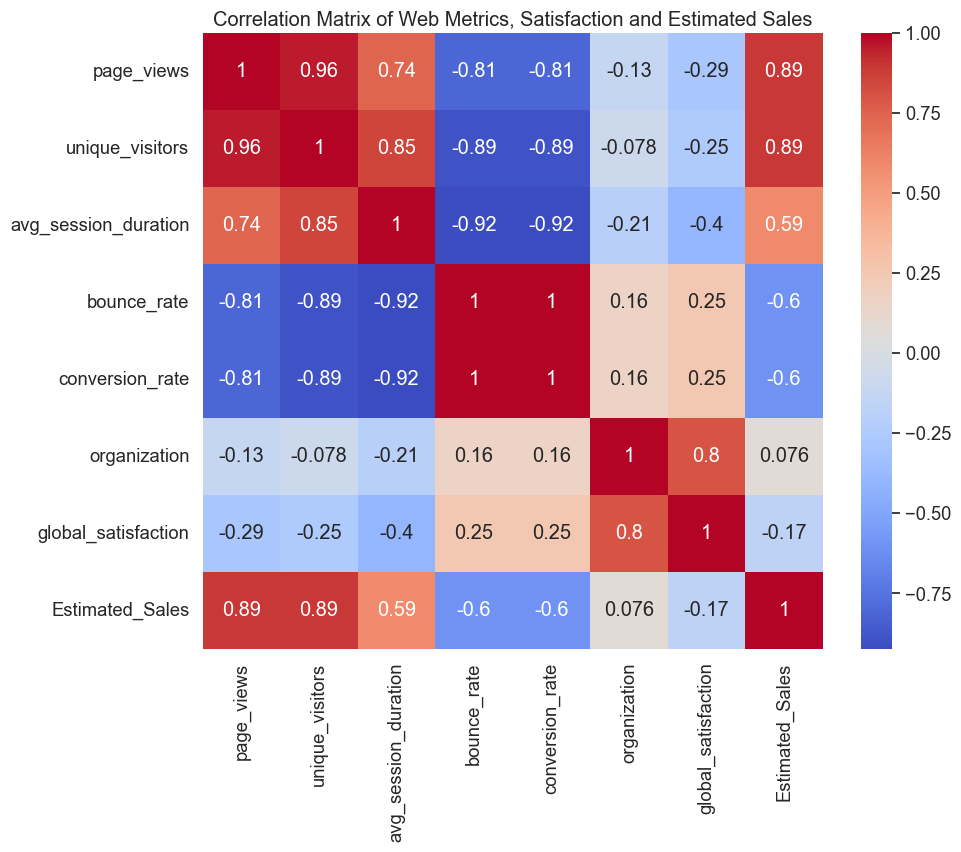

In [12]:
trip_analytics_satisfaction['Estimated_Sales'] = trip_analytics_satisfaction['conversion_rate'] * trip_analytics_satisfaction['unique_visitors']
correlation_matrix = trip_analytics_satisfaction[['page_views', 'unique_visitors', 'avg_session_duration', 'bounce_rate', 'conversion_rate', 'organization', 'global_satisfaction', 'Estimated_Sales']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Web Metrics, Satisfaction and Estimated Sales')
plt.show()

C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\2577782221.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  operator_sales = sales_data.groupby(['Year', 'Operator ID']).size().reset_index(name='Sales')


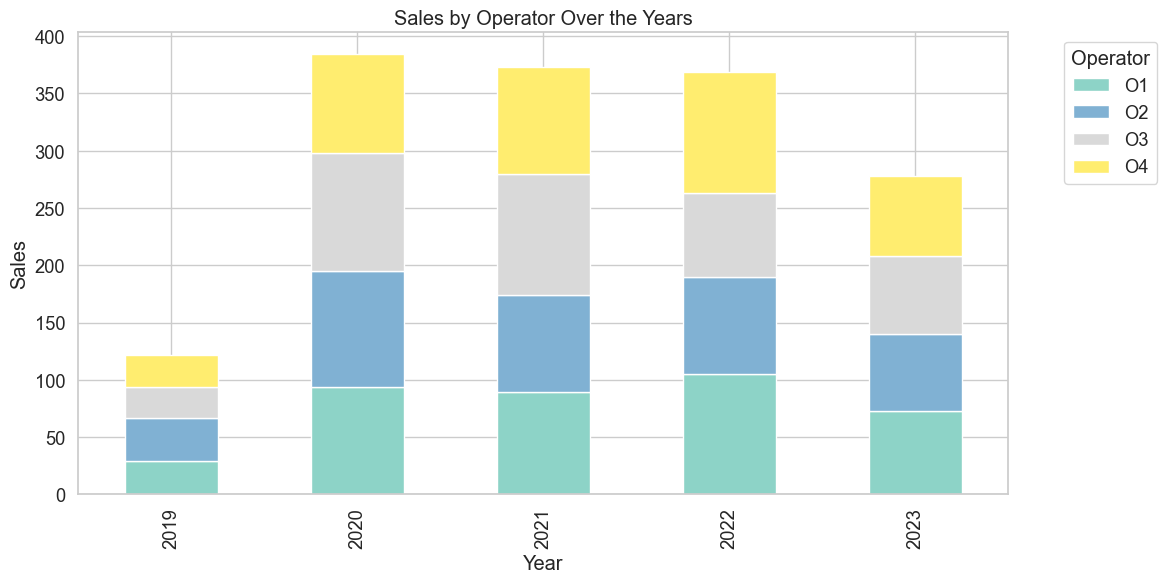

In [13]:
operator_sales = sales_data.groupby(['Year', 'Operator ID']).size().reset_index(name='Sales')
operator_sales = operator_sales.pivot(index='Year', columns='Operator ID', values='Sales')
operator_sales

operator_sales.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set3')
plt.title('Sales by Operator Over the Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Operator', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

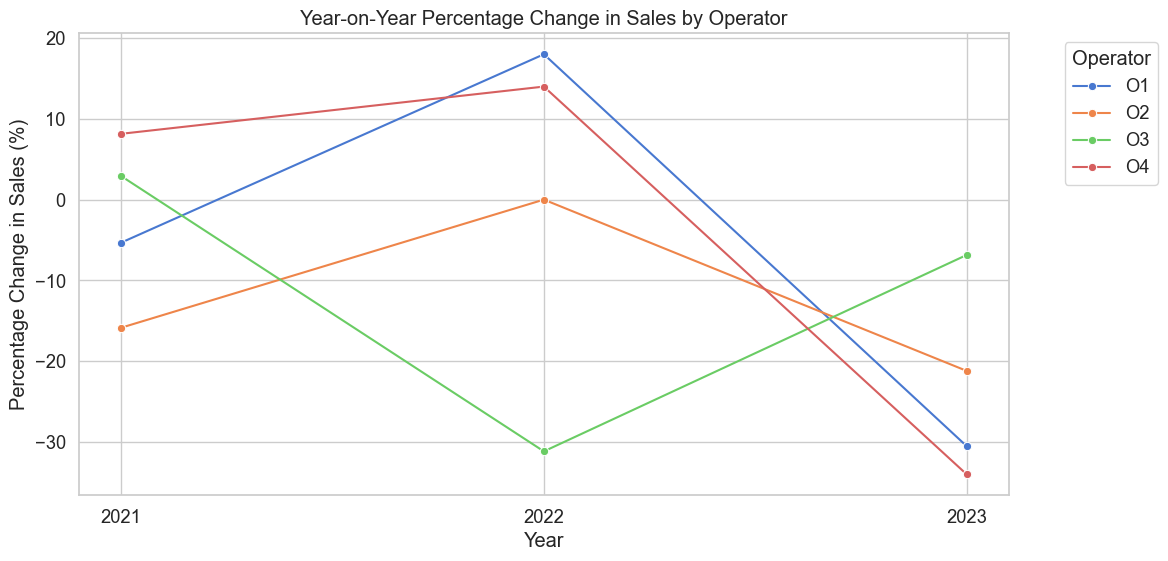

In [14]:
operator_sales_pct_change = operator_sales.pct_change() * 100
operator_sales_pct_change = operator_sales_pct_change.reset_index().melt(id_vars='Year', var_name='Operator ID', value_name='Percent_Change')
operator_sales_pct_change.dropna(inplace=True)
operator_sales_pct_change

plt.figure(figsize=(12,6))
sns.lineplot(data=operator_sales_pct_change[operator_sales_pct_change['Year'] >= 2021], x='Year', y='Percent_Change', hue='Operator ID', marker='o')

plt.title('Year-on-Year Percentage Change in Sales by Operator')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Sales (%)')
plt.grid(True)
plt.legend(title='Operator', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([2021, 2022, 2023])
plt.show()

C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\3803465739.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  operator_funnel = transactions.groupby(['Year', 'Operator ID', 'Status'])['Customer ID'].nunique().reset_index(name='Customers')
C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\3803465739.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  operator_funnel = operator_funnel.pivot_table(index=['Year', 'Operator ID'], columns = 'Status', values='Customers', fill_value=0).reset_index()


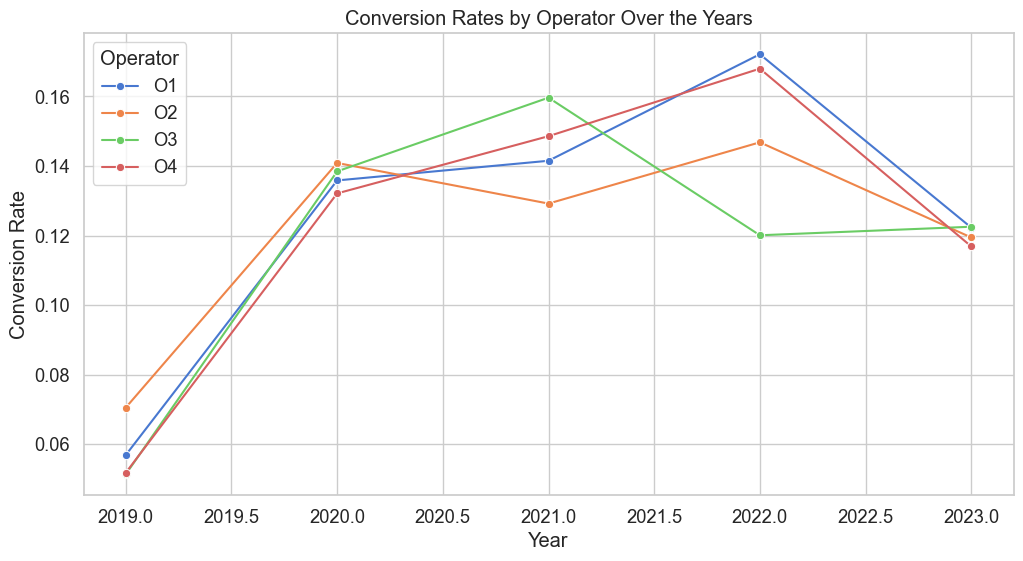

In [15]:
operator_funnel = transactions.groupby(['Year', 'Operator ID', 'Status'])['Customer ID'].nunique().reset_index(name='Customers')
operator_funnel = operator_funnel.pivot_table(index=['Year', 'Operator ID'], columns = 'Status', values='Customers', fill_value=0).reset_index()
operator_funnel['Conversion_Rate'] = operator_funnel['Sales']/operator_funnel['Filled in form']

plt.figure(figsize=(12,6))
sns.lineplot(data=operator_funnel, x='Year', y='Conversion_Rate', hue='Operator ID', marker='o')
plt.title('Conversion Rates by Operator Over the Years')
plt.xlabel('Year')
plt.ylabel('Conversion Rate')
plt.legend(title='Operator')
plt.grid(True)
plt.show()

In [16]:
avg_scores_per_year = scores.groupby('Year')[['organization', 'global_satisfaction']].mean().reset_index()
avg_scores_per_year['Year'] = avg_scores_per_year['Year'] + 2000
sales_and_satisfaction = pd.merge(avg_scores_per_year, sales_per_year.drop(columns=['YoY Change (%)']), on = 'Year', how='inner')

# Set colors and styles
color1 = 'tab:blue'
color2 = 'tab:red'

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot average satisfaction scores on ax1
lns1 = ax1.plot(
    sales_and_satisfaction['Year'],
    sales_and_satisfaction['global_satisfaction'],
    marker='o',
    label='Global Satisfaction',
    color=color1,
    linewidth=2
)
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Satisfaction Score', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

# Create a second y-axis for 'Total_Sales'
ax2 = ax1.twinx()
lns2 = ax2.plot(
    sales_and_satisfaction['Year'],
    sales_and_satisfaction['Total_Sales'],
    marker='o',
    label='Total Sales',
    color=color2,
    linewidth=2
)
ax2.set_ylabel('Total Sales', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper center')
ax1.set_xticks(sales_and_satisfaction['Year'])
ax1.set_xticklabels(sales_and_satisfaction['Year'].astype(str))

plt.title('Average Global Satisfaction Scores and Total Sales Over Time')
plt.show()

# Group by 'period' to calculate average satisfaction scores for each period
avg_satisfaction_per_period = scores.groupby('period')[['organization', 'global_satisfaction']].mean()


plt.figure(figsize=(12, 6))  
plt.plot(avg_satisfaction_per_period.index, avg_satisfaction_per_period['organization'], marker='o', label='Average Organization Rating')
plt.plot(avg_satisfaction_per_period.index, avg_satisfaction_per_period['global_satisfaction'], marker='o', label='Average Global Satisfaction')


plt.title('Average Satisfaction Scores by Period') 
plt.xlabel('Period') xis as 'Period'.
plt.ylabel('Average Satisfaction Score')  
plt.xticks(avg_satisfaction_per_period.index)  
plt.legend()  
plt.grid(True) 
plt.show() ot.


# 2. Correlation Analysis
correlation_matrix = scores[['organization', 'global_satisfaction', 'Year']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Satisfaction Analysis')
plt.show()


SyntaxError: invalid syntax (100179535.py, line 58)

In [ ]:
avg_scores_per_trip = scores.groupby('Trip')[['organization', 'global_satisfaction']].mean().reset_index()

top_trips = avg_scores_per_trip.sort_values('global_satisfaction', ascending=False).head(5)
worse_trips = avg_scores_per_trip.sort_values('global_satisfaction').head(5)

print("Top 5 Trips by Global Satisfaction Score:")
print(top_trips)

print("\nBottom 5 Trips by Global Satisfaction Score:")
print(worse_trips)

Trip                   0
Year                   0
organization           0
global_satisfaction    0
dtype: int64


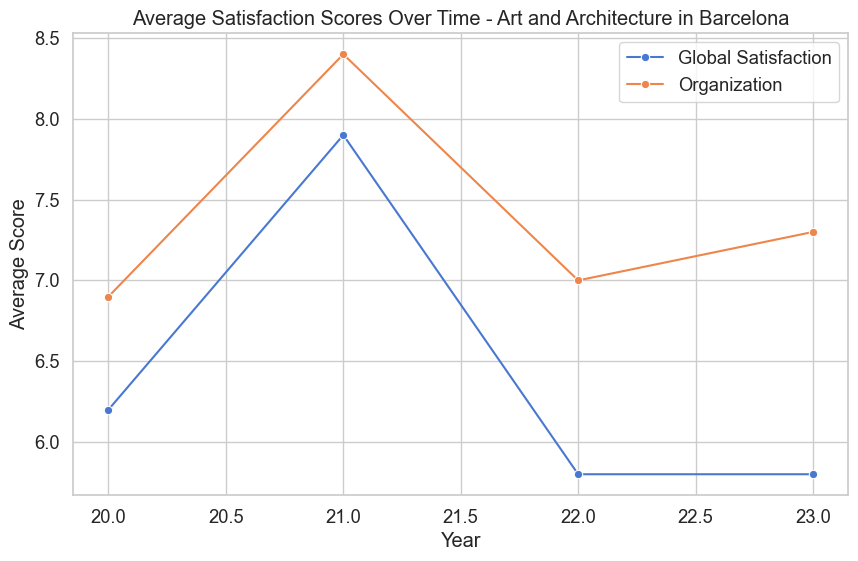

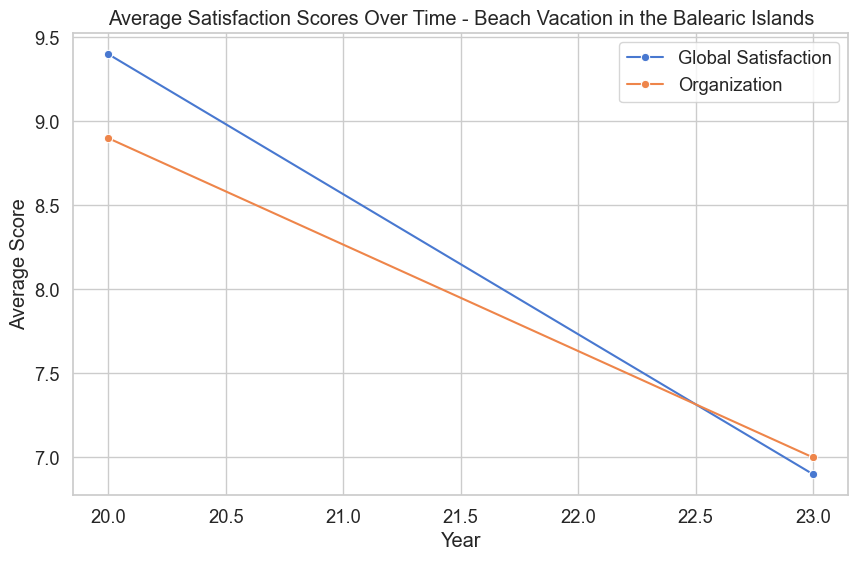

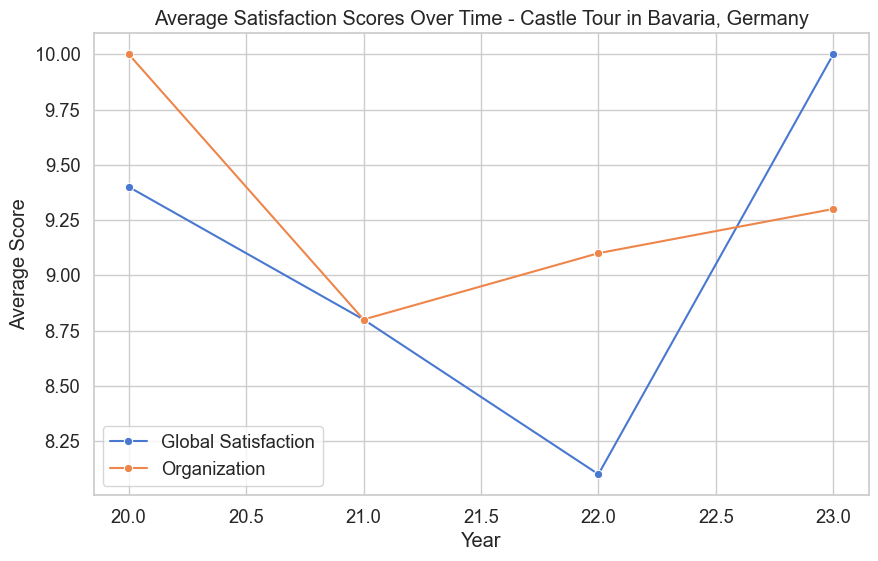

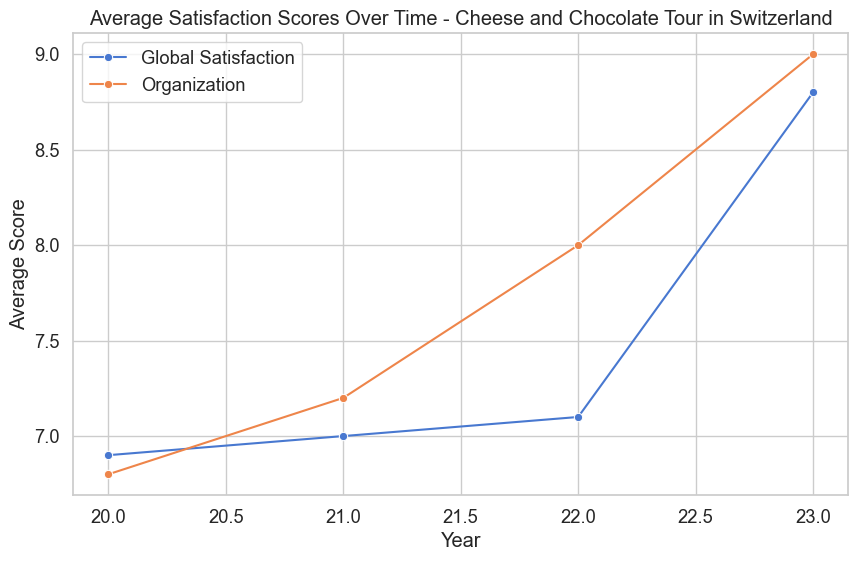

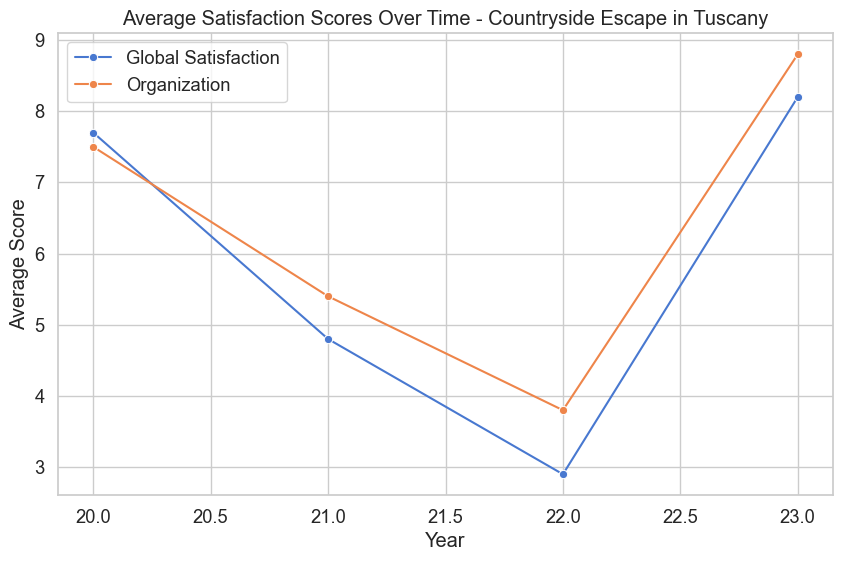

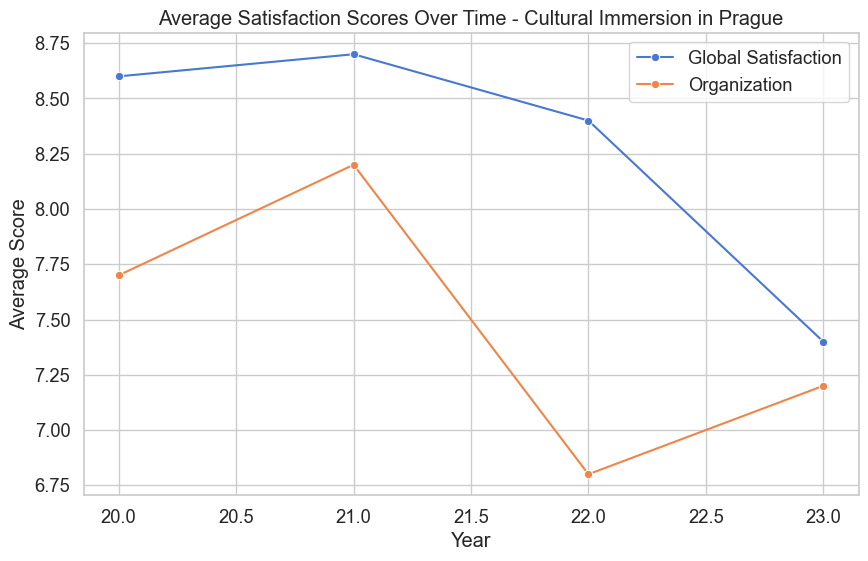

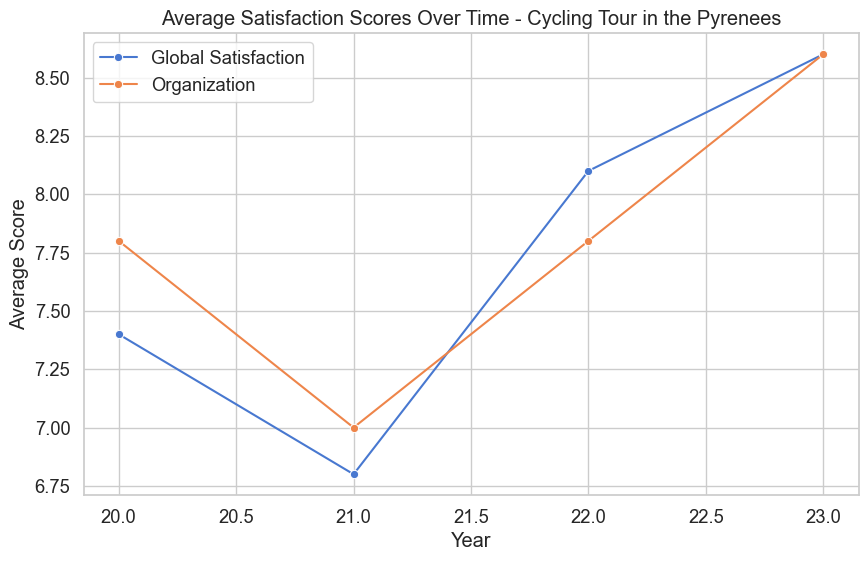

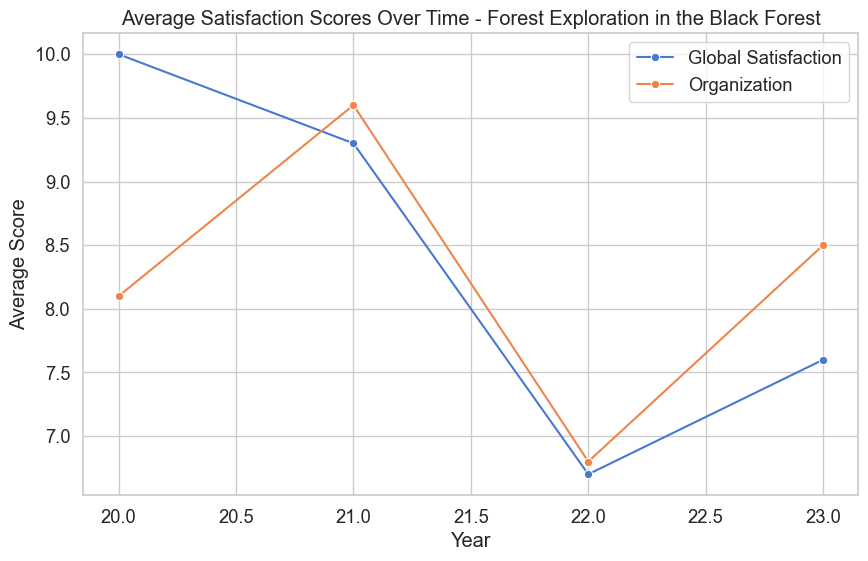

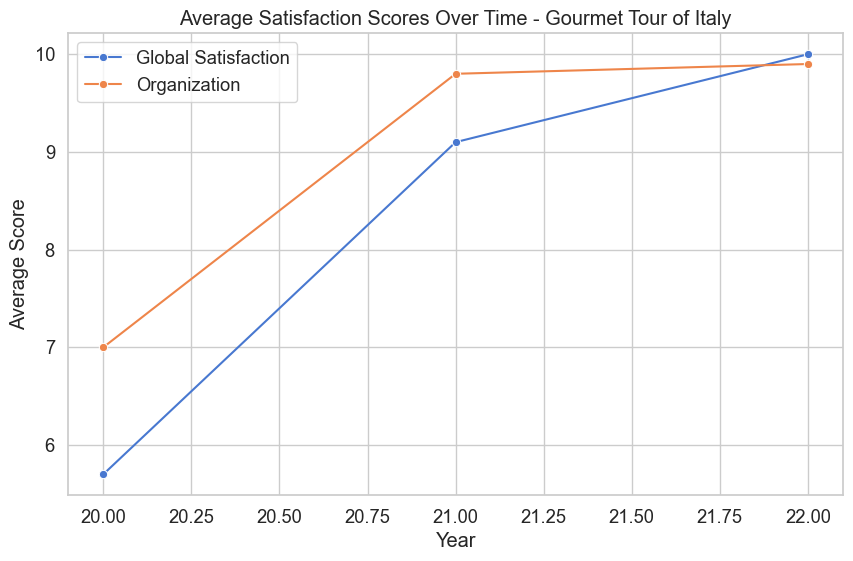

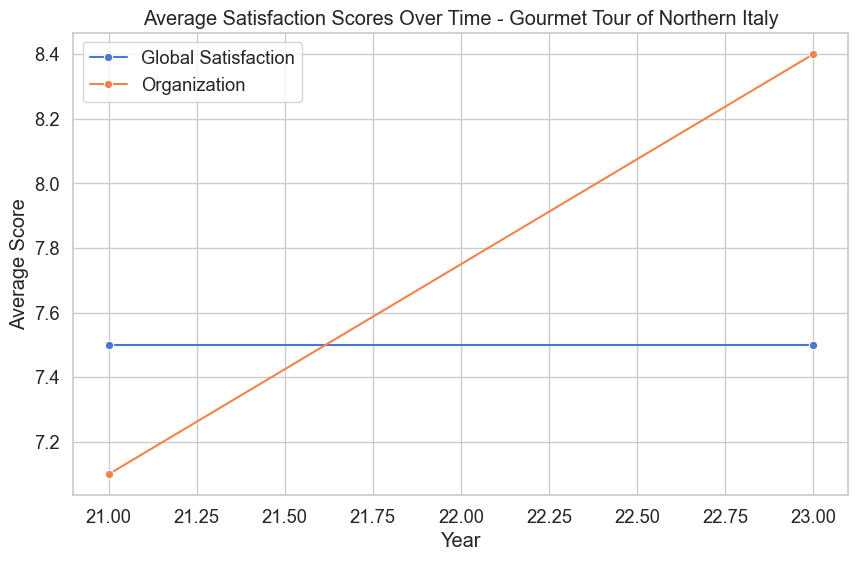

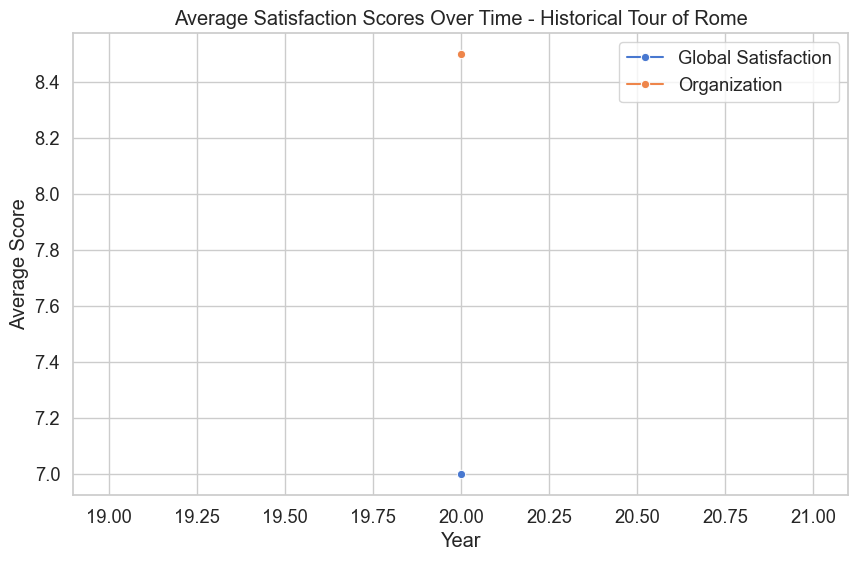

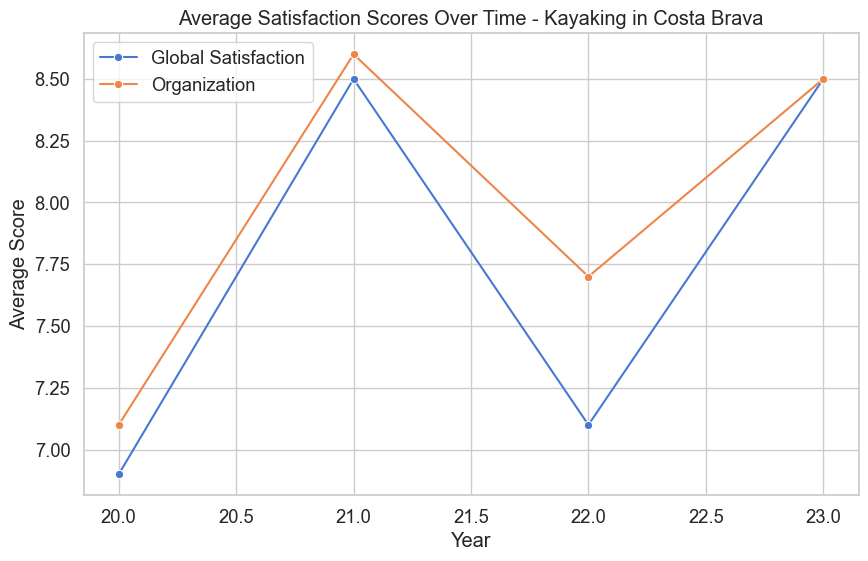

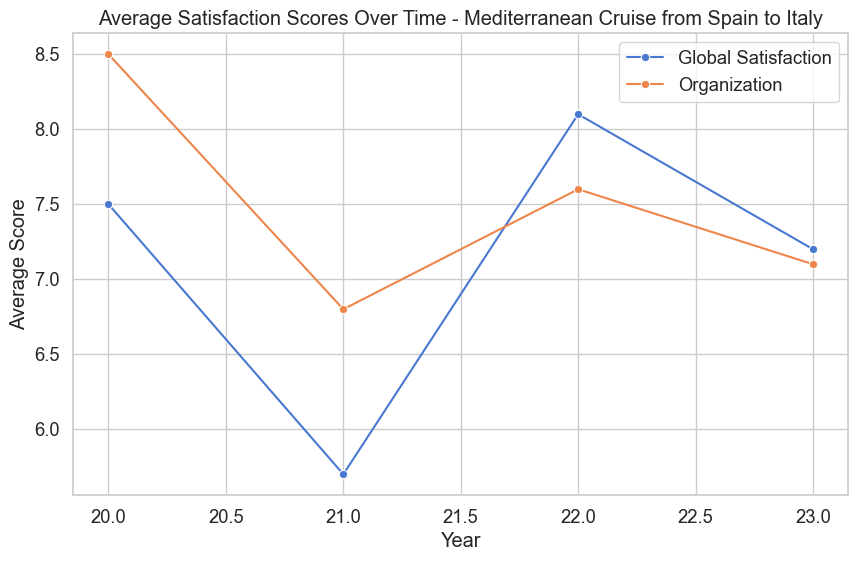

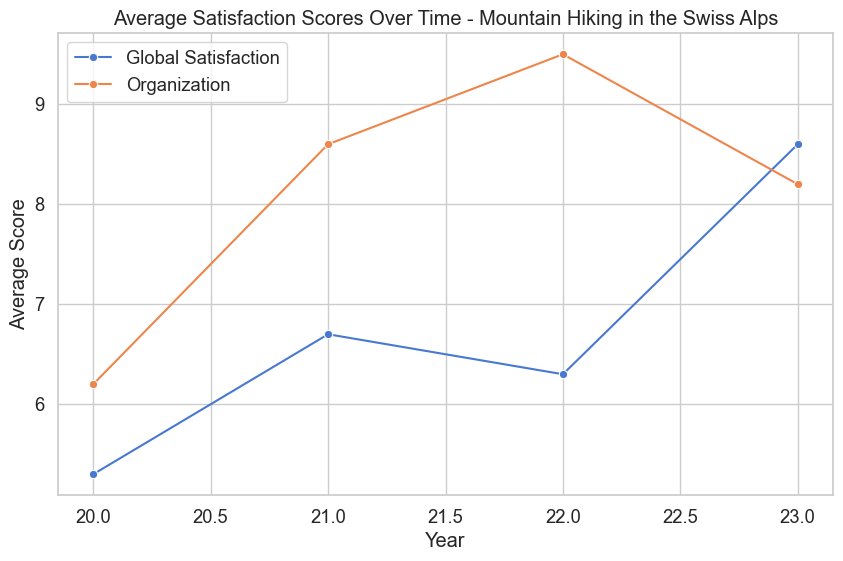

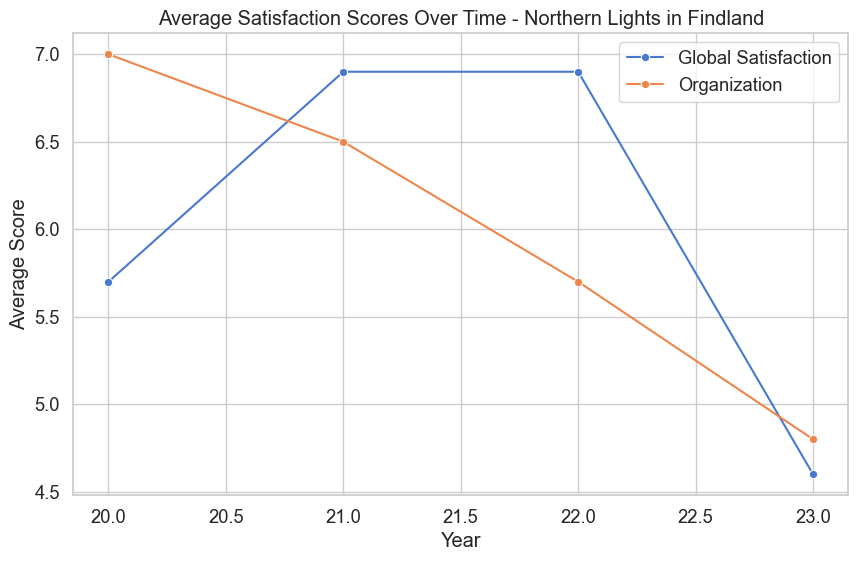

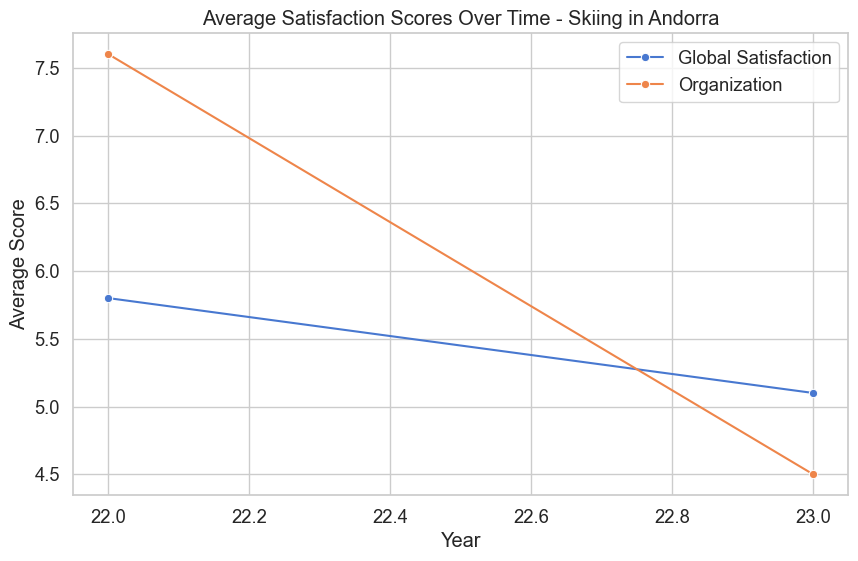

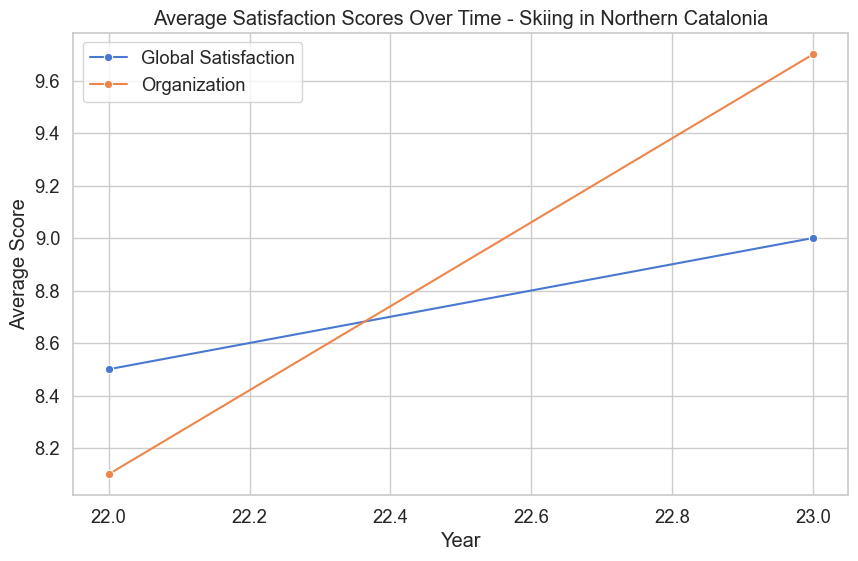

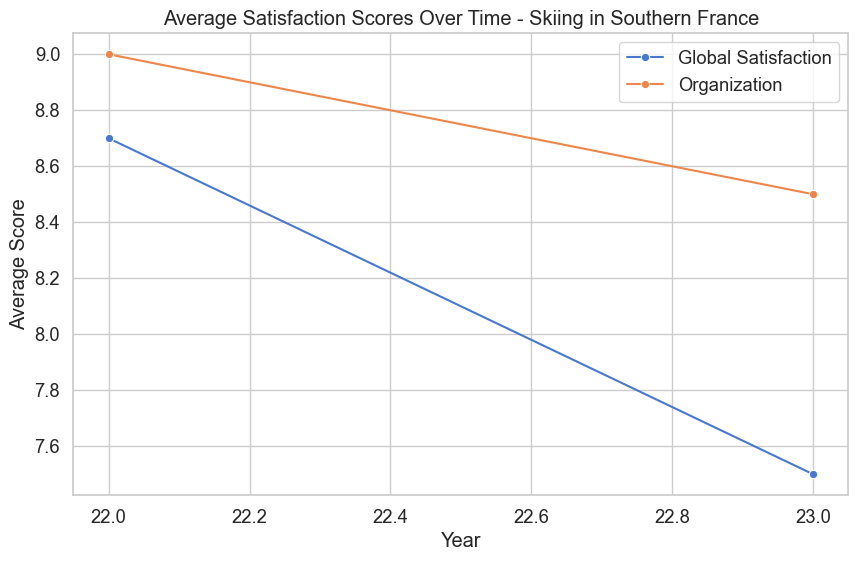

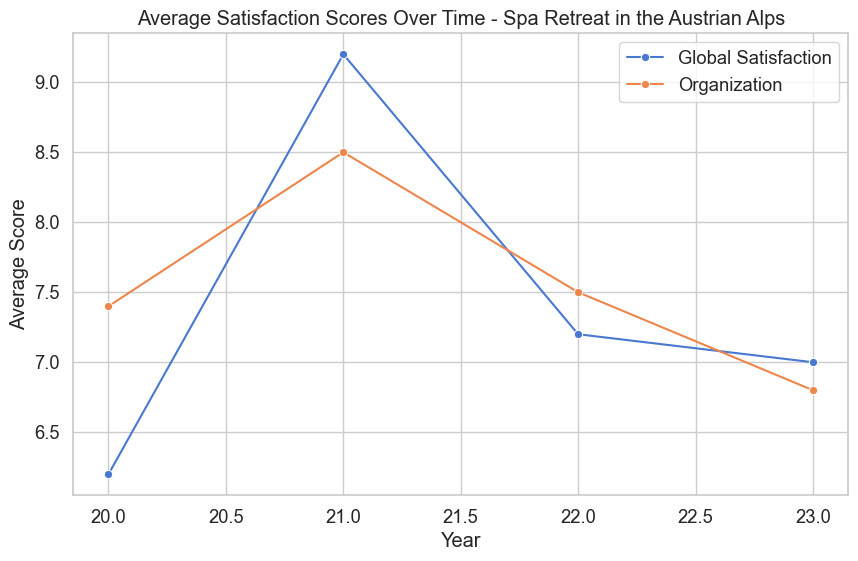

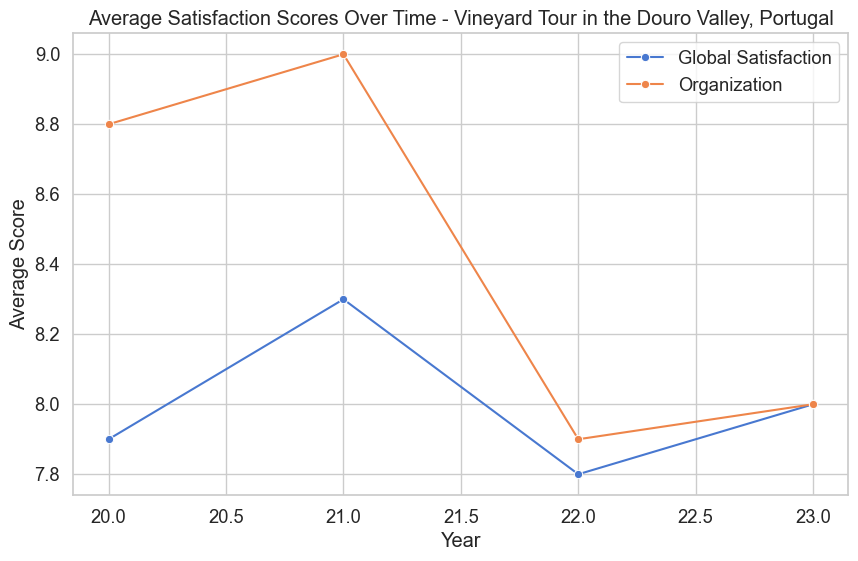

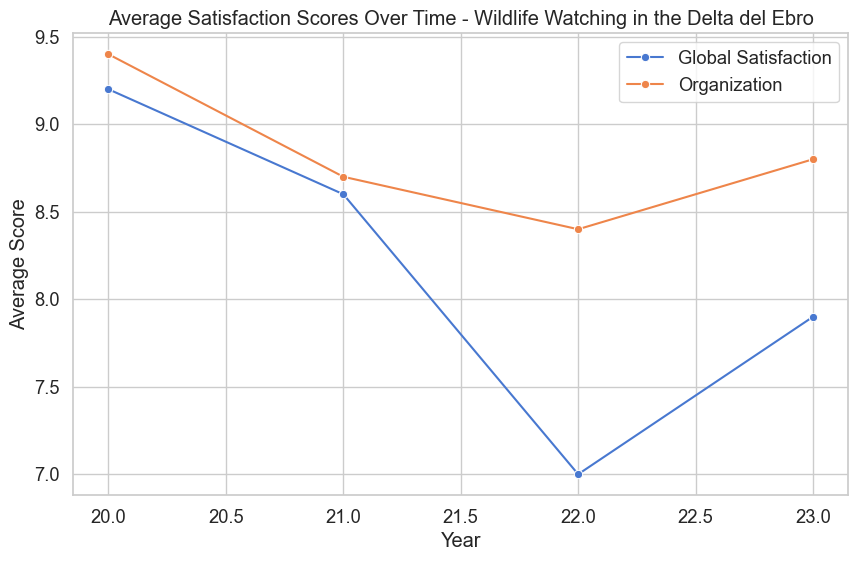

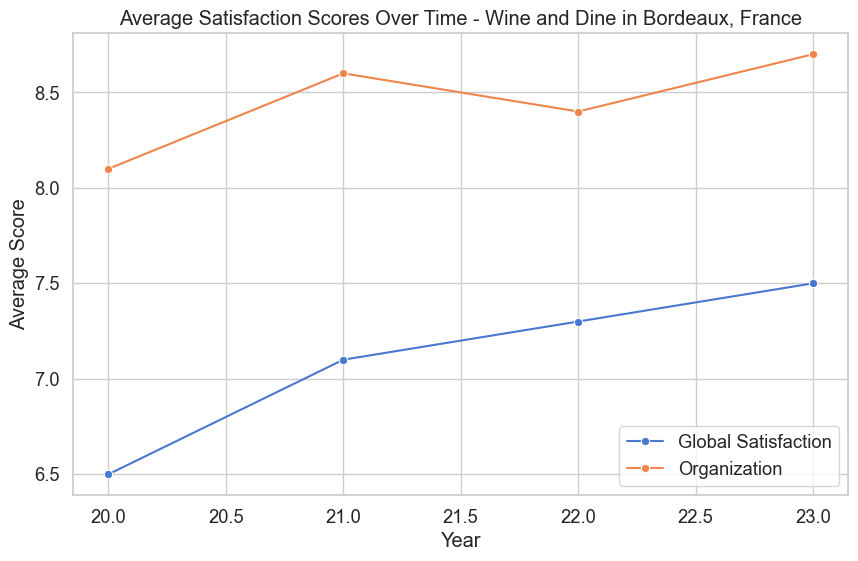

In [17]:

scores['Trip'] = scores['Trip'].str.strip()

print(scores[['Trip', 'Year', 'organization', 'global_satisfaction']].isnull().sum())
avg_scores_trip_year = scores.groupby(['Trip', 'Year'])[['organization', 'global_satisfaction']].mean().reset_index()

trips = avg_scores_trip_year['Trip'].unique()

# Plot satisfaction scores over time for each trip
for trip in trips:
    trip_data = avg_scores_trip_year[avg_scores_trip_year['Trip'] == trip]
    plt.figure(figsize=(10,6))
    sns.lineplot(data=trip_data, x='Year', y='global_satisfaction', marker='o', label='Global Satisfaction')
    sns.lineplot(data=trip_data, x='Year', y='organization', marker='o', label='Organization')
    plt.title(f'Average Satisfaction Scores Over Time - {trip}')
    plt.xlabel('Year')
    plt.ylabel('Average Score')
    plt.legend()
    plt.grid(True)
    plt.show()

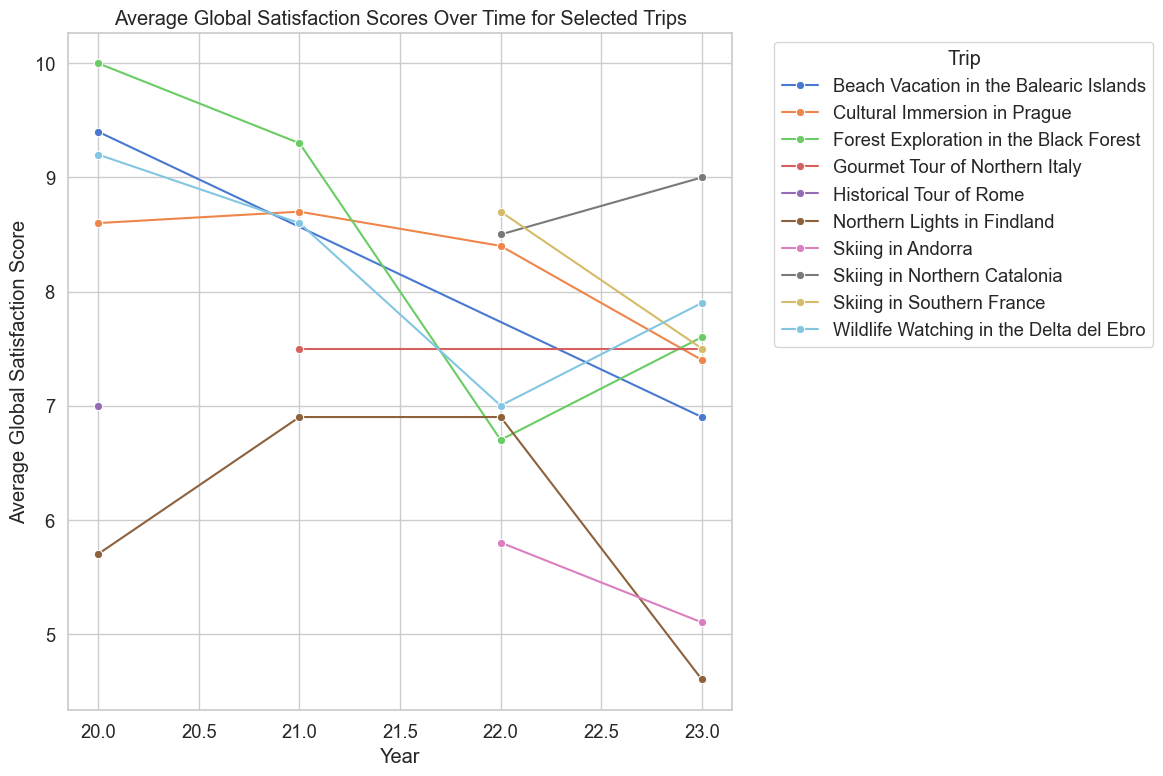

In [18]:
first_year = avg_scores_trip_year['Year'].min()
last_year = avg_scores_trip_year['Year'].max()

pivot_scores = avg_scores_trip_year.pivot(index='Trip', columns='Year', values='global_satisfaction')

# Calculate the change between the first and last year
pivot_scores['Score_Change'] = pivot_scores[last_year] - pivot_scores[first_year]
pivot_scores.reset_index(inplace=True)


pivot_scores.sort_values('Score_Change', inplace=True)

# Top 5 trips with declining satisfaction
declining_trips = pivot_scores.head(5)['Trip'].tolist()

# Top 5 trips with improving satisfaction
improving_trips = pivot_scores.tail(5)['Trip'].tolist()

selected_trips = declining_trips + improving_trips

selected_trips_data = avg_scores_trip_year[avg_scores_trip_year['Trip'].isin(selected_trips)]

# Plot satisfaction scores over time for selected trips
plt.figure(figsize=(12,8))
sns.lineplot(data=selected_trips_data, x='Year', y='global_satisfaction', hue='Trip', marker='o')
plt.title('Average Global Satisfaction Scores Over Time for Selected Trips')
plt.xlabel('Year')
plt.ylabel('Average Global Satisfaction Score')
plt.legend(title='Trip', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Calculate standard deviation of global satisfaction scores per trip
score_variability = scores.groupby('Trip')['global_satisfaction'].std().reset_index()
score_variability.rename(columns={'global_satisfaction': 'Score_STD'}, inplace=True)

trip_stats = avg_scores_trip_year.groupby('Trip')['global_satisfaction'].mean().reset_index()
trip_stats = trip_stats.merge(score_variability, on='Trip')

# Sort trips by score variability
trip_stats.sort_values('Score_STD', ascending=False, inplace=True)

print("Trips with Highest Variability in Satisfaction Scores:")
print(trip_stats.head(10))

Trips with Highest Variability in Satisfaction Scores:
                                        Trip  global_satisfaction  Score_STD
4              Countryside Escape in Tuscany             5.900000   2.499333
8                      Gourmet Tour of Italy             8.266667   2.267892
1     Beach Vacation in the Balearic Islands             8.150000   1.767767
7     Forest Exploration in the Black Forest             8.400000   1.516575
13         Mountain Hiking in the Swiss Alps             6.725000   1.381726
18          Spa Retreat in the Austrian Alps             7.400000   1.275408
14               Northern Lights in Findland             6.025000   1.105667
12  Mediterranean Cruise from Spain to Italy             7.125000   1.021029
0          Art and Architecture in Barcelona             6.425000   1.001249
20   Wildlife Watching in the Delta del Ebro             8.175000   0.946485


In [20]:

budget_units = pd.read_csv('data/budget_units.csv', delimiter = ';')

budget_units_melted = budget_units.melt(id_vars=['Trip'], var_name='Year_Period', value_name='Budget_Category')
budget_units_melted['Year'] = budget_units_melted['Year_Period'].str.extract('(\d+)$').astype(int)
budget_units_melted['Trip'] = budget_units_melted['Trip'].str.strip()

print(budget_units_melted[budget_units_melted['Trip'] == 'Historical Tour of Rome'])

# Clean data
def clean_budget(value):
    if pd.isnull(value):
        return np.nan
    elif isinstance(value, str):
        value = value.strip()
        if value.isdigit():
            num_to_letter = {1:'A', 2:'B', 3:'C', 4:'D'}
            return num_to_letter.get(int(value), np.nan)
        elif value in ['A', 'B', 'C', 'D']:
            return value
        else:
            return np.nan

budget_units_melted['Budget_Category'] = budget_units_melted['Budget_Category'].apply(clean_budget)
budget_units_melted.dropna(subset=['Budget_Category'], inplace=True)
budget_units_melted = budget_units_melted[['Trip', 'Year', 'Budget_Category']]

scores_with_budget = pd.merge(scores, budget_units_melted, on=['Trip', 'Year'], how='inner')
scores_with_budget.dropna(subset=['Budget_Category', 'global_satisfaction'], inplace=True)
scores_with_budget

                       Trip Year_Period Budget_Category  Year
10  Historical Tour of Rome   period_20               4    20
32  Historical Tour of Rome   period_21             NaN    21
54  Historical Tour of Rome   period_22             NaN    22
76  Historical Tour of Rome   period_23             NaN    23
98  Historical Tour of Rome   period_24             NaN    24


,Trip,organization,global_satisfaction,period,Year,Budget_Category
0,Mountain Hiking in the Swiss Alps,6.2,5.3,3,20,B
1,Kayaking in Costa Brava,7.1,6.9,1,20,A
2,Cycling Tour in the Pyrenees,7.8,7.4,2,20,A
3,Historical Tour of Rome,8.5,7.0,4,20,D
4,Cultural Immersion in Prague,7.7,8.6,1,20,B
...,...,...,...,...,...,...
69,Cheese and Chocolate Tour in Switzerland,9.0,8.8,2,23,B
70,Gourmet Tour of Northern Italy,8.4,7.5,3,23,B
71,Mediterranean Cruise from Spain to Italy,7.1,7.2,3,23,C
72,"Castle Tour in Bavaria, Germany",9.3,10.0,3,23,B


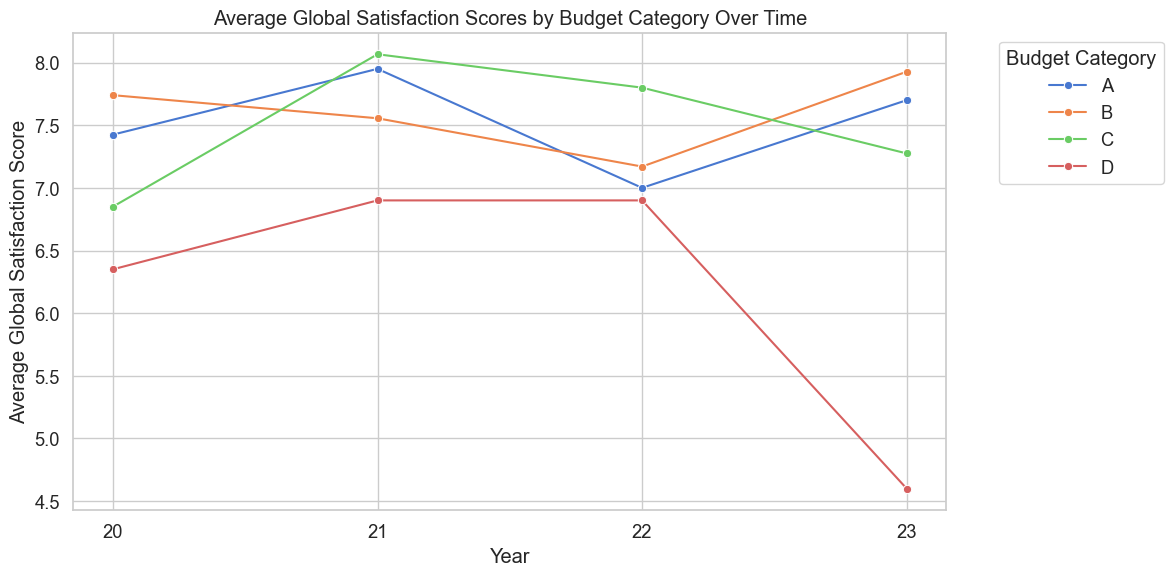

Change in Global Satisfaction Scores from 20 to 23:
  Budget_Category  Score_Change
3               D     -1.750000
1               B      0.187273
0               A      0.275000
2               C      0.425000


In [21]:
avg_satisfaction_per_budget = scores_with_budget.groupby(['Year', 'Budget_Category'])['global_satisfaction'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_satisfaction_per_budget,
    x='Year',
    y='global_satisfaction',
    hue='Budget_Category',
    marker='o'
)
plt.title('Average Global Satisfaction Scores by Budget Category Over Time')
plt.xlabel('Year')
plt.ylabel('Average Global Satisfaction Score')
plt.legend(title='Budget Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks([20, 21, 22, 23])
plt.tight_layout()
plt.show()

first_year = avg_satisfaction_per_budget['Year'].min()
last_year = avg_satisfaction_per_budget['Year'].max()

budget_score_change = avg_satisfaction_per_budget[avg_satisfaction_per_budget['Year'] == last_year].set_index('Budget_Category')['global_satisfaction'] - \
                      avg_satisfaction_per_budget[avg_satisfaction_per_budget['Year'] == first_year].set_index('Budget_Category')['global_satisfaction']

budget_score_change = budget_score_change.reset_index()
budget_score_change.rename(columns={'global_satisfaction':'Score_Change'}, inplace=True)
budget_score_change.sort_values('Score_Change', inplace=True)

print("Change in Global Satisfaction Scores from {} to {}:".format(first_year, last_year))
print(budget_score_change)

In [22]:
overall_avg_satisfaction = scores_with_budget.groupby('Budget_Category')['global_satisfaction'].mean().reset_index()
overall_avg_satisfaction.sort_values('global_satisfaction', ascending=False, inplace=True)
print('Overall Average Global Satisfaction per Budget Category:')
print(overall_avg_satisfaction)

Overall Average Global Satisfaction per Budget Category:
  Budget_Category  global_satisfaction
1               B             7.607500
2               C             7.553846
0               A             7.518750
3               D             6.220000


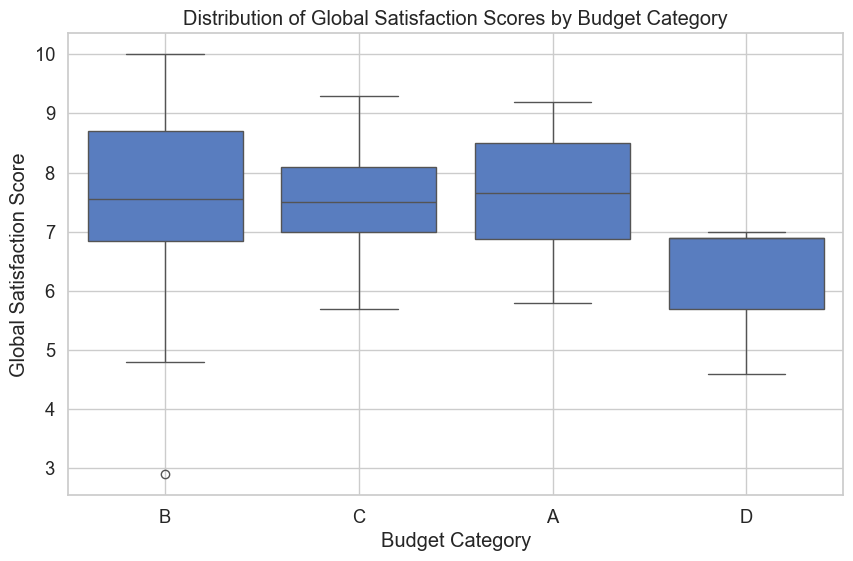

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=scores_with_budget,
    x='Budget_Category',
    y='global_satisfaction',
    order=overall_avg_satisfaction['Budget_Category']
)
plt.title('Distribution of Global Satisfaction Scores by Budget Category')
plt.xlabel('Budget Category')
plt.ylabel('Global Satisfaction Score')
plt.grid(True)
plt.show()

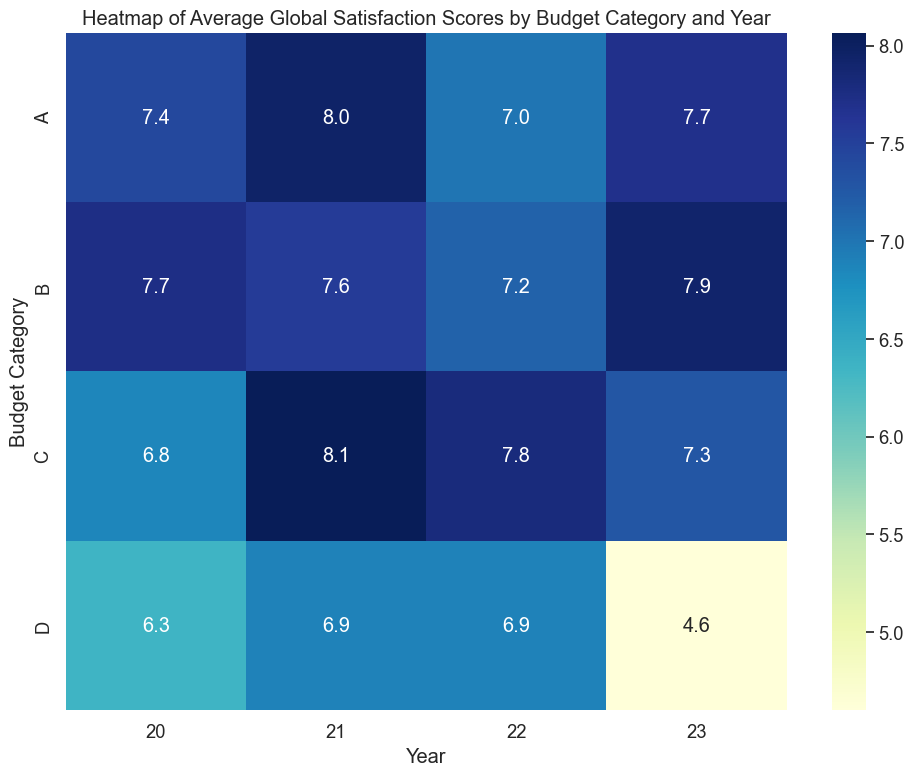

In [24]:
# Pivot data for heatmap
heatmap_data = avg_satisfaction_per_budget.pivot(index='Budget_Category', columns='Year', values='global_satisfaction')

plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Heatmap of Average Global Satisfaction Scores by Budget Category and Year')
plt.xlabel('Year')
plt.ylabel('Budget Category')
plt.tight_layout()
plt.show()

In [25]:
budget_units_melted

,Trip,Year,Budget_Category
0,Art and Architecture in Barcelona,20,A
1,Beach Vacation in the Balearic Islands,20,B
2,"Castle Tour in Bavaria, Germany",20,B
3,Cheese and Chocolate Tour in Switzerland,20,B
4,Countryside Escape in Tuscany,20,B
...,...,...,...
88,Art and Architecture in Barcelona,24,A
93,Cultural Immersion in Prague,24,B
99,Kayaking in Costa Brava,24,A
102,Northern Lights in Findland,24,D


In [26]:
budget_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
scores_with_budget['Budget_Num'] = scores_with_budget['Budget_Category'].map(budget_mapping)

# Correlation analysis
correlation = scores_with_budget[['Budget_Num', 'global_satisfaction']].corr()
print("Correlation between Budget Category and Global Satisfaction:")
print(correlation)

Correlation between Budget Category and Global Satisfaction:
                     Budget_Num  global_satisfaction
Budget_Num             1.000000            -0.152363
global_satisfaction   -0.152363             1.000000


In [27]:
# Calculate average satisfaction per Trip and Budget Category
avg_satisfaction_trip_budget = scores_with_budget.groupby(['Budget_Category', 'Trip'])['global_satisfaction'].mean().reset_index()

# For each budget category, find trips with the lowest satisfaction
underperforming_trips = avg_satisfaction_trip_budget.groupby('Budget_Category').apply(lambda x: x.nsmallest(3, 'global_satisfaction')).reset_index(drop=True)

print("Underperforming Trips within Each Budget Category:")
print(underperforming_trips)

Underperforming Trips within Each Budget Category:
   Budget_Category                                      Trip  \
0                A         Art and Architecture in Barcelona   
1                A              Cycling Tour in the Pyrenees   
2                A                   Kayaking in Costa Brava   
3                B                         Skiing in Andorra   
4                B             Countryside Escape in Tuscany   
5                B         Mountain Hiking in the Swiss Alps   
6                C    Beach Vacation in the Balearic Islands   
7                C  Mediterranean Cruise from Spain to Italy   
8                C          Spa Retreat in the Austrian Alps   
9                D               Northern Lights in Findland   
10               D                   Historical Tour of Rome   

    global_satisfaction  
0                 6.425  
1                 7.725  
2                 7.750  
3                 5.450  
4                 5.900  
5                 6.725 

C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\1780550328.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  underperforming_trips = avg_satisfaction_trip_budget.groupby('Budget_Category').apply(lambda x: x.nsmallest(3, 'global_satisfaction')).reset_index(drop=True)


In [28]:
prediction_list = []
trips = scores['Trip'].unique()

for trip in trips:
    trip_data = scores[scores['Trip'] == trip][['Year', 'organization', 'global_satisfaction']]
    if trip_data['Year'].nunique() > 1:
        # Multiple years of data available
        X = trip_data[['Year']]
        y_org = trip_data['organization']
        y_sat = trip_data['global_satisfaction']
        
        # Linear Regression for 'organization'
        reg_org = LinearRegression().fit(X, y_org)
        pred_org = reg_org.predict([[24]])[0]
        
        # Linear Regression for 'global_satisfaction'
        reg_sat = LinearRegression().fit(X, y_sat)
        pred_sat = reg_sat.predict([[24]])[0]
        
    else:
        pred_org = trip_data['organization'].values[0]
        pred_sat = trip_data['global_satisfaction'].values[0]
    
    prediction_list.append({
        'Trip': trip,
        'Year': 24,
        'organization': pred_org,
        'global_satisfaction': pred_sat
    })

# Convert the list of predictions to a DataFrame
predictions = pd.DataFrame(prediction_list)
scores_no_period = scores.drop(columns='period')
column_order = ['Trip', 'Year', 'organization', 'global_satisfaction']
predictions = predictions[column_order]
scores_no_period = scores_no_period[column_order]
predicted_scores = pd.concat([scores_no_period, predictions], ignore_index=True)
predicted_scores


C:\Users\rsast\PycharmProjects\IntrotoAI\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rsast\PycharmProjects\IntrotoAI\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rsast\PycharmProjects\IntrotoAI\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rsast\PycharmProjects\IntrotoAI\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\rsast\PycharmProjects\IntrotoAI\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  

,Trip,Year,organization,global_satisfaction
0,Mountain Hiking in the Swiss Alps,20,6.20,5.30
1,Kayaking in Costa Brava,20,7.10,6.90
2,Cycling Tour in the Pyrenees,20,7.80,7.40
3,Historical Tour of Rome,20,8.50,7.00
4,Cultural Immersion in Prague,20,7.70,8.60
...,...,...,...,...
91,"Vineyard Tour in the Douro Valley, Portugal",24,7.55,7.95
92,Gourmet Tour of Northern Italy,24,9.05,7.50
93,Skiing in Andorra,24,1.40,4.40
94,Skiing in Southern France,24,8.00,6.30


In [29]:
budget_units_melt = budget_units.melt(id_vars=['Trip'], var_name='Year_Period', value_name='Budget_Category')
budget_units_melt['Year'] = budget_units_melt['Year_Period'].str.extract('(\d+)$').astype(int)
budget_units_melt['Trip'] = budget_units_melt['Trip'].str.strip()

budget_23 = budget_units_melt[budget_units_melt['Year'] == 23][['Trip', 'Budget_Category']]
budget_24 = budget_units_melt[(budget_units_melt['Year'] == 24) & (budget_units_melt['Budget_Category'].isna())]['Trip']

# For these trips, carry forward the budget category from period_23
budget_carryover = budget_23[budget_23['Trip'].isin(budget_24)].copy()
budget_carryover['Year'] = 24
budget_units_melt = pd.concat([budget_units_melt, budget_carryover], ignore_index=True)
budget_units_melt = budget_units_melt.drop(columns=['Year_Period'])
# Remove remaining rows in period 24 with missing values
budget_units_melt = budget_units_melt[~((budget_units_melt['Year'] == 24) & (budget_units_melt['Budget_Category'].isna()))]
budget_units_melt

,Trip,Budget_Category,Year
0,Art and Architecture in Barcelona,A,20
1,Beach Vacation in the Balearic Islands,B,20
2,"Castle Tour in Bavaria, Germany",B,20
3,Cheese and Chocolate Tour in Switzerland,B,20
4,Countryside Escape in Tuscany,B,20
...,...,...,...
122,Skiing in Northern Catalonia,B,24
123,Skiing in Southern France,B,24
124,"Vineyard Tour in the Douro Valley, Portugal",C,24
125,Wildlife Watching in the Delta del Ebro,A,24


C:\Users\rsast\AppData\Local\Temp\ipykernel_11056\4075728286.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_budget_2024['Trip'] = scores_budget_2024['Trip'].replace({


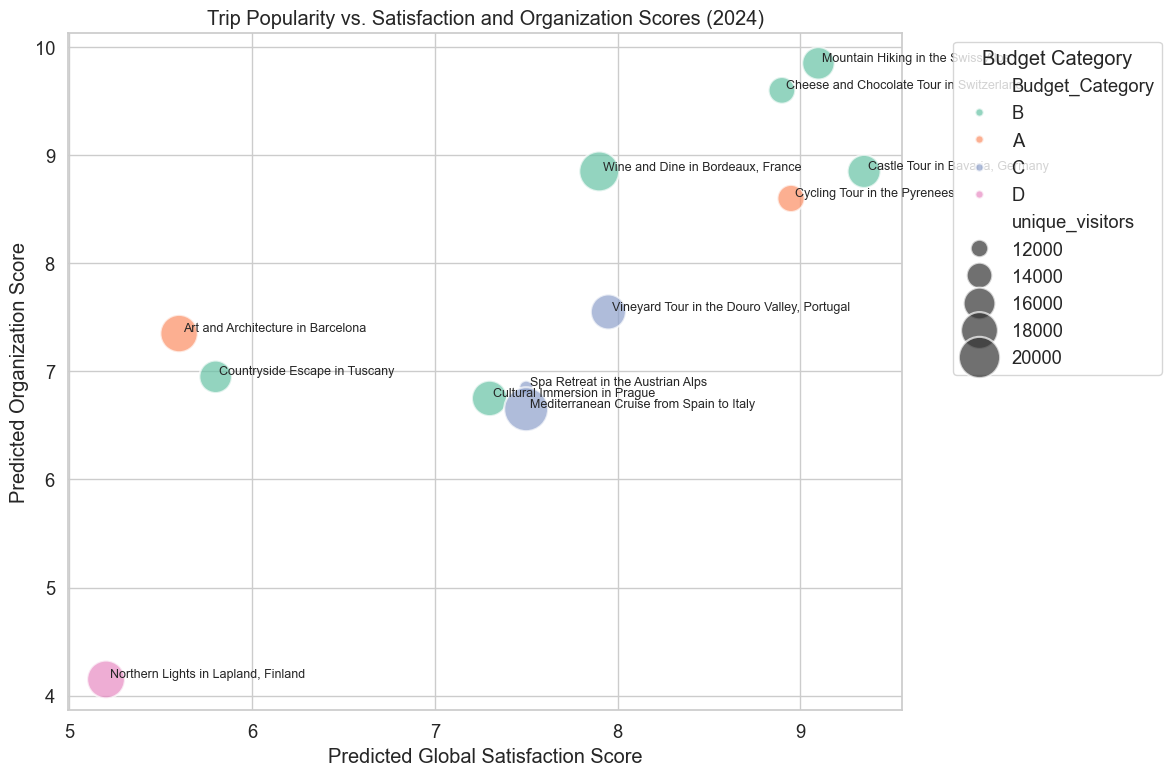

In [30]:
scores_budget = pd.merge(
    predicted_scores,
    budget_units_melt[['Trip', 'Year', 'Budget_Category']],
    on=['Trip', 'Year'],
    how='inner'
)

analytics_data_subset = analytics_data[['trip_name', 'unique_visitors']]
analytics_data_subset = analytics_data_subset.rename(columns={'trip_name':'Trip'})
analytics_data_subset['Trip'] = analytics_data_subset['Trip'].str.strip()


scores_budget_2024 = scores_budget[scores_budget['Year'] == 24]

scores_budget_2024['Trip'] = scores_budget_2024['Trip'].replace({
    'Northern Lights in Findland':'Northern Lights in Lapland, Finland'
})


final_data = pd.merge(
    scores_budget_2024,
    analytics_data_subset,
    on='Trip',
    how='inner'
)


final_data.dropna(
    subset=['organization', 'global_satisfaction', 'unique_visitors', 'Budget_Category'],
    inplace=True
)


plt.figure(figsize=(12,8))

# Create scatter plot
sns.scatterplot(
    data=final_data,
    x='global_satisfaction',
    y='organization',
    size='unique_visitors',
    hue='Budget_Category',
    sizes=(100, 1000),  # Adjust bubble sizes as needed
    alpha=0.7,
    palette='Set2'
)

# Annotate each point with the trip name
for idx, row in final_data.iterrows():
    plt.text(
        x=row['global_satisfaction'] + 0.02,
        y=row['organization'] + 0.02,
        s=row['Trip'],
        fontsize=9
    )

plt.title('Trip Popularity vs. Satisfaction and Organization Scores (2024)')
plt.xlabel('Predicted Global Satisfaction Score')
plt.ylabel('Predicted Organization Score')
plt.legend(title='Budget Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()